## This notebook has results from CNN, VGG 16, DenseNet 121, ChexNet

In [ ]:
class Tokenizer():
    
    def __init__(self):
        self.word_index = {}
        self.index_word = {0: "<start>", 1: "<end>"}
        self.vocab_size = 2
        
        
    def fit(self, arr):
        self.word_index = {}
        self.index_word = {0: "<start>", 1: "<end>"}
        self.vocab_size = 2
        
        for word in arr:
            if word not in self.word_index:
                self.index_word[self.vocab_size] = word
                self.word_index[word] = self.vocab_size
                self.vocab_size += 1
                    
    def transform(self, sentence):
        return [0] + [self.word_index[word] for word in sentence] + [1]
    
    def reverse_transform(self, encoded_sentence):
        return [self.index_word[num] for num in encoded_sentence[1:-1]]

In [ ]:
import os
from PIL import Image

import torch
from torch.utils.data import Dataset
from torchvision import transforms

class ImgCapDataset(Dataset):
    def __init__(self, df, img_dir):
        self.df = df
        self.img_dir = img_dir
        self.image_transform = transforms.Compose([
                transforms.Resize((512, 512)),
                transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_1 = os.path.join(self.img_dir, self.df.iloc[idx]["Image1"] + ".png")
        img_1 = Image.open(img_1)
        img_1 = self.image_transform(img_1)
        
        img_2 = os.path.join(self.img_dir, self.df.iloc[idx]["Image2"] + ".png")
        img_2 = Image.open(img_2)
        img_2 = self.image_transform(img_2)
        
        caption = torch.LongTensor(self.df.iloc[idx]["CaptionSeq"])

        return img_1, img_2, caption

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import vgg16
from torchvision.models import densenet121

class CNN_Encoder(nn.Module):
    
    def __init__(self):
        super(CNN_Encoder, self).__init__()
        self.conv = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding='same')
        self.fc = nn.Linear(256*256*16, 128)

        self.conv2 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding='same')
        self.fc2 = nn.Linear(256*256*16, 128)

    def forward(self, x1, x2):
        x1 = F.relu(self.conv(x1))
        x1 = F.max_pool2d(x1, 2)
        x1 = torch.flatten(x1, 1)
        x1 = self.fc(x1)

        x2 = F.relu(self.conv2(x2))
        x2 = F.max_pool2d(x2, 2)
        x2 = torch.flatten(x2, 1)
        x2 = self.fc2(x2)

        return torch.cat((x1, x2), 1)
    
class VGG_Encoder(nn.Module):
    
    def __init__(self):
        super(VGG_Encoder, self).__init__()
        self.vgg1 = vgg16(pretrained=True)
        seq1 = list(self.vgg1.classifier)
        seq1[-1] = nn.Linear(4096, 1024, bias=True)
        seq1.append(nn.ReLU(inplace=True))
        seq1.append(nn.Dropout(p=0.5, inplace=False))
        seq1.append(nn.Linear(1024, 128, bias=True))
        self.vgg1.classifier = nn.Sequential(*seq1)
        
        for param in self.vgg1.features.parameters():
            param.requires_grad = False
        
        self.vgg2 = vgg16(pretrained=True)
        seq2 = list(self.vgg2.classifier)
        seq2[-1] = nn.Linear(4096, 1024, bias=True)
        seq2.append(nn.ReLU(inplace=True))
        seq2.append(nn.Dropout(p=0.5, inplace=False))
        seq2.append(nn.Linear(1024, 128, bias=True))
        self.vgg2.classifier = nn.Sequential(*seq2)
        
        for param in self.vgg2.features.parameters():
            param.requires_grad = False
        
    def forward(self, x1, x2):
        
        x1 = self.vgg1(x1)
        x2 = self.vgg2(x2)
        
        return torch.cat((x1, x2), 1)
    
class DN_Encoder(nn.Module):
    
    def __init__(self):
        super(DN_Encoder, self).__init__()
        self.dn1 = densenet121(pretrained=True)
        self.dn1.classifier = nn.Linear(1024, 128, bias=True)
        
        for param in self.dn1.features.parameters():
            param.requires_grad = False
        
        self.dn2 = densenet121(pretrained=True)
        self.dn2.classifier = nn.Linear(1024, 128, bias=True)
        
        for param in self.dn2.features.parameters():
            param.requires_grad = False
        
    def forward(self, x1, x2):
        
        x1 = self.dn1(x1)
        x2 = self.dn2(x2)
        
        return torch.cat((x1, x2), 1)
    
class Chex_Encoder(nn.Module):
    
    def __init__(self):
        super(Chex_Encoder, self).__init__()
        weights = torch.load('../input/chexnet/m-30012020-104001.pth.tar')
        self.dn1 = densenet121(pretrained=False)
        self.dn1.load_state_dict(weights['state_dict'], strict=False)
        self.dn1.classifier = nn.Linear(1024, 128, bias=True)
        
        for param in self.dn1.features.parameters():
            param.requires_grad = False
        
        self.dn2 = densenet121(pretrained=False)
        self.dn2.load_state_dict(weights['state_dict'], strict=False)
        self.dn2.classifier = nn.Linear(1024, 128, bias=True)
        
        for param in self.dn2.features.parameters():
            param.requires_grad = False
        
    def forward(self, x1, x2):
        
        x1 = self.dn1(x1)
        x2 = self.dn2(x2)
        
        return torch.cat((x1, x2), 1)
        

class RNN_Decoder(nn.Module):

    def __init__(self, embed_size, hidden_size, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.LSTMCell(embed_size, hidden_size)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, caption):

        cap = torch.transpose(self.embed(caption), 0, 1)
        output = torch.empty((caption.size(0), caption.size(1), self.vocab_size))

        for i in range(caption.size(1)):

            if i == 0:
                device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
                h = torch.autograd.Variable(torch.zeros(x.size(0), self.hidden_size)).to(device)
                c = torch.autograd.Variable(torch.zeros(x.size(0), self.hidden_size)).to(device)
                h, c = self.rnn(x, (h ,c))
            else:
                h, c = self.rnn(cap[i,:,:], (h, c))

            output[:,i,:] = self.fc(h)

        return output

In [ ]:
!pip install biobert-embedding

  Preparing metadata (setup.py) ... - done
     |████████████████████████████████| 748.9 MB 537 bytes/s          
     |████████████████████████████████| 123 kB 64.8 MB/s            
  Preparing metadata (setup.py) ... - done
  Created wheel for biobert-embedding: filename=biobert_embedding-0.1.2-py3-none-any.whl size=5701 sha256=385e5db3652c351d28f612e5e712899699f3bcbae76f51d851bdb8460ff579b8
  Stored in directory: /root/.cache/pip/wheels/67/26/c2/176e174845e1612a5d607eea1d1876e2c9aca2b5654a5cd681
  Created wheel for wrapt: filename=wrapt-1.12.1-cp37-cp37m-linux_x86_64.whl size=77058 sha256=c84fdb6f5c56a847c6f36e20ae3b0970f07c64a7136317efcb1e798b99467323
  Stored in directory: /root/.cache/pip/wheels/62/76/4c/aa25851149f3f6d9785f6c869387ad82b3fd37582fa8147ac6
Successfully built biobert-embedding wrapt
  Attempting uninstall: six
    Found existing installation: six 1.16.0
    Uninstalling six-1.16.0:
      Successfully uninstalled six-1.16.0
  Attempting uninstall: typing-extensio

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.spatial.distance import cosine
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from biobert_embedding.embedding import BiobertEmbedding

class BaseModel():
    
    def __init__(self, train_df, test_df, image_address, sentence_length, vocab_size, epoch, encoder_name):
        
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        self.df = df.sample(frac=1).reset_index(drop=True)
        self.train_df, self.val_df = self.train_val_split(train_df)
        
        train_ds = ImgCapDataset(self.train_df, image_address)
        val_ds = ImgCapDataset(self.val_df, image_address)
        test_ds = ImgCapDataset(test_df, image_address)
        
        self.train_dl = DataLoader(train_ds, batch_size=16, shuffle=True)
        self.val_dl = DataLoader(val_ds, batch_size=16, shuffle=True)
        self.test_dl = DataLoader(test_ds, batch_size=1, shuffle=True)
        
        self.EPOCH = epoch
        
        if encoder_name == "CNN":
            self.encoder = CNN_Encoder()
        elif encoder_name == "VGG":
            self.encoder = VGG_Encoder()
        elif encoder_name == "DenseNet":
            self.encoder = DN_Encoder()
        elif encoder_name == "ChexNet":
            self.encoder = Chex_Encoder()
        self.decoder = RNN_Decoder(256, sentence_length, vocab_size)
        
        self.encoder = self.encoder.to(device)
        self.decoder = self.decoder.to(device)
        
        self.encoder_optim = torch.optim.Adam(self.encoder.parameters(), 0.0001)
        self.decoder_optim = torch.optim.Adam(self.decoder.parameters(), 0.0001)
        self.LOSS = torch.nn.CrossEntropyLoss()
        
    def train_val_split(self, df):
        split = 4*len(df)//5
        train = df.iloc[:split,:]
        val = df.iloc[split:,:]
        return train, val
    
    def train(self):
        self._training_loop(
            self.EPOCH, self.encoder, self.decoder, self.encoder_optim, 
            self.decoder_optim, self.LOSS, self.train_dl, self.val_dl
        )
        
    def _training_loop(self, epochs, encoder, decoder, encoder_optimizer, decoder_optimizer, loss_f, train_loader, val_loader):
        
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        for epoch in range(epochs):
            loss_train = 0.0
            for x1, x2, y in train_loader:
                x1 = x1.to(device)
                x2 = x2.to(device)
                y = y.to(device)
                
                out = encoder(x1, x2)
                out = decoder(out, y)
                out = out.to(device)
                loss = loss_f(torch.flatten(out, 0, 1), torch.flatten(y))

                encoder_optimizer.zero_grad()
                decoder_optimizer.zero_grad()
                loss.backward()
                encoder_optimizer.step()
                decoder_optimizer.step()
                loss_train += loss.item()
            
            with torch.no_grad():
                loss_val = 0.0
                for x1, x2, y in val_loader:
                    x1 = x1.to(device)
                    x2 = x2.to(device)
                    y = y.to(device)

                    out = encoder(x1, x2)
                    out = decoder(out, y)
                    out = out.to(device)
                    loss = loss_f(torch.flatten(out, 0, 1), torch.flatten(y))
                    loss_val += loss.item()
                print("Epoch", epoch, "Train Loss", loss_train/len(train_loader), "Validation Loss", loss_val/len(val_loader))
    
    def sample(self, tokenizer):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        x1, x2, c = next(iter(self.test_dl))
        x1 = x1.to(device)
        x2 = x2.to(device)
        c = c.to(device)
        out1 = self.encoder.forward(x1, x2)
        out2 = self.decoder.forward(out1, c)
        encoded_out = torch.argmax(out2, dim=2).cpu().detach().numpy()

        decoded_out = " ".join([tokenizer.index_word[x] for x in encoded_out[0] if x not in (0, 1)])
            
        c = c.cpu().detach().numpy()
            
        real = " ".join([tokenizer.index_word[x] for x in c[0] if x not in (0, 1)])

        fig, ax = plt.subplots(1, 2)
        ax[0].imshow(x1[0].permute(1, 2, 0).cpu().detach().numpy())
        ax[1].imshow(x2[0].permute(1, 2, 0).cpu().detach().numpy())
        plt.show()
        print("Prediction:", decoded_out)
        print("Caption:", real)
        
    def evaluate(self, tokenizer):
        
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        dist = []
        counter = 0
        for x1, x2, c in self.test_dl:
            
            if counter > 200:
                break
            
            x1 = x1.to(device)
            x2 = x2.to(device)
            c = c.to(device)
            out1 = self.encoder.forward(x1, x2)
            out2 = self.decoder.forward(out1, c)
            encoded_out = torch.argmax(out2, dim=2).cpu().detach().numpy()

            decoded_out = " ".join([tokenizer.index_word[x] for x in encoded_out[0] if x not in (0, 1)])
            c = c.cpu().detach().numpy()
            real = " ".join([tokenizer.index_word[x] for x in c[0] if x not in (0, 1)])

            biobert = BiobertEmbedding()
            preds = biobert.sentence_vector(decoded_out)
            caps = biobert.sentence_vector(real)
            dist.append(cosine(preds, caps))
            counter += 1
            
        return np.mean(dist)
        
        

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from functools import reduce
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchtext
from torch.utils.data import DataLoader
from torchtext.data.metrics import bleu_score

In [ ]:
df = pd.read_csv("../input/imagecaption/data/processed.csv")
df = df[["Image1", "Image2", "Clean_capt"]]
df.columns = ["Image1", "Image2", "Caption"]
print(df.shape)
df.head()

(4017, 3)


,Image1,Image2,Caption
0,CXR162_IM-0401-1001,CXR162_IM-0401-2001,normal chest
1,CXR1390_IM-0249-1001,CXR1390_IM-0249-2001,no evidence active disease
2,CXR604_IM-2193-1001,CXR604_IM-2193-2001,no evidence active disease
3,CXR2699_IM-1167-1001,CXR2699_IM-1167-2001,no acute cardiopulmonary disease
4,CXR2841_IM-1253-2001,CXR2841_IM-1253-2001,no acute cardiopulmonary disease


In [ ]:
tokenizer = Tokenizer()
tokenizer.fit(reduce(lambda a, b: a+b, df.Caption.str.split()))
cap = df.Caption.apply(lambda x: tokenizer.transform(x.split()))
cap_len = cap.apply(len).value_counts().sort_index()
cap_len

3       10
4      109
5      469
6     1443
7      292
      ... 
65       1
66       1
86       1
89       1
90       2
Name: Caption, Length: 63, dtype: int64

In [ ]:
LENGTH = 64
seq_trim = cap_len[cap_len.index > LENGTH]
print("If trimmed by length %d, %d captions will be trimmed" % (LENGTH, seq_trim.sum()))
print("If trimmed by length %d, %.2f%% of captions will be trimmed" % (LENGTH, seq_trim.sum()*100/len(df)))

If trimmed by length 64, 6 captions will be trimmed
If trimmed by length 64, 0.15% of captions will be trimmed


In [ ]:
train_df = pd.read_csv("../input/train-test/train.csv")
train_df = train_df[["Image1", "Image2", "Clean_capt"]]
train_df.columns = ["Image1", "Image2", "Caption"]
print(train_df.shape)
train_df.head()

(3214, 3)


,Image1,Image2,Caption
0,CXR588_IM-2183-1001,CXR588_IM-2183-2001,no acute cardiopulmonary abnormality
1,CXR2937_IM-1339-1001,CXR2937_IM-1339-2001,no acute cardiopulmonary finding
2,CXR255_IM-1058-1001,CXR255_IM-1058-2001,no acute cardiopulmonary disease
3,CXR1679_IM-0448-1001,CXR1679_IM-0448-1002,normal chest
4,CXR2660_IM-1142-1001,CXR2660_IM-1142-2001,normal chest


In [ ]:
test_df = pd.read_csv("../input/train-test/test.csv")
test_df = test_df[["Image1", "Image2", "Clean_capt"]]
test_df.columns = ["Image1", "Image2", "Caption"]
print(test_df.shape)
test_df.head()

(803, 3)


,Image1,Image2,Caption
0,CXR2590_IM-1083-1001,CXR2590_IM-1083-2001,no acute disease
1,CXR3057_IM-1424-1001-0001,CXR3057_IM-1424-1001-0001,no acute cardiopulmonary disease
2,CXR3446_IM-1669-1001,CXR3446_IM-1669-2001,negative chest x xxxx
3,CXR1017_IM-0013-1001,CXR1017_IM-0013-1002,no active disease
4,CXR1204_IM-0138-1001,CXR1204_IM-0138-2001,no acute cardiopulmonary disease


In [ ]:
train_cap = train_df.Caption.apply(lambda x: tokenizer.transform(x.split()))
test_cap = test_df.Caption.apply(lambda x: tokenizer.transform(x.split()))

train_df["CaptionSeq"] = train_cap.apply(lambda x: x + [1] * (LENGTH - len(x)) if len(x) < LENGTH else x[:LENGTH])
test_df["CaptionSeq"] = test_cap.apply(lambda x: x + [1] * (LENGTH - len(x)) if len(x) < LENGTH else x[:LENGTH])

train_df.head()

,Image1,Image2,Caption,CaptionSeq
0,CXR588_IM-2183-1001,CXR588_IM-2183-2001,no acute cardiopulmonary abnormality,"[0, 4, 8, 9, 11, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,..."
1,CXR2937_IM-1339-1001,CXR2937_IM-1339-2001,no acute cardiopulmonary finding,"[0, 4, 8, 9, 12, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,..."
2,CXR255_IM-1058-1001,CXR255_IM-1058-2001,no acute cardiopulmonary disease,"[0, 4, 8, 9, 7, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,CXR1679_IM-0448-1001,CXR1679_IM-0448-1002,normal chest,"[0, 2, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,CXR2660_IM-1142-1001,CXR2660_IM-1142-2001,normal chest,"[0, 2, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


In [ ]:
cnn_model = BaseModel(train_df, test_df, "../input/imagecaption/data/images", LENGTH, tokenizer.vocab_size, 20, "CNN")
cnn_model.train()

Epoch 0 Train Loss 4.707470002381698 Validation Loss 3.3212749492831346
Epoch 1 Train Loss 1.8670751619042818 Validation Loss 2.0427840802727677
Epoch 2 Train Loss 1.0704740719025179 Validation Loss 1.6711539059150509
Epoch 3 Train Loss 0.815874967886054 Validation Loss 1.496095442190403
Epoch 4 Train Loss 0.6679887118176644 Validation Loss 1.377899780506041
Epoch 5 Train Loss 0.5729311833285397 Validation Loss 1.2513699444328867
Epoch 6 Train Loss 0.5048686091018759 Validation Loss 1.1702909077086099
Epoch 7 Train Loss 0.45323517492839266 Validation Loss 1.0986227422225765
Epoch 8 Train Loss 0.4121284322431369 Validation Loss 1.0499570587786233
Epoch 9 Train Loss 0.37774756592438086 Validation Loss 0.9947750699229356
Epoch 10 Train Loss 0.3490066909179184 Validation Loss 0.9215384910746318
Epoch 11 Train Loss 0.3232896231022311 Validation Loss 0.90192615695116
Epoch 12 Train Loss 0.30095622461775073 Validation Loss 0.8462953829183811
Epoch 13 Train Loss 0.2814997905252143 Validation L

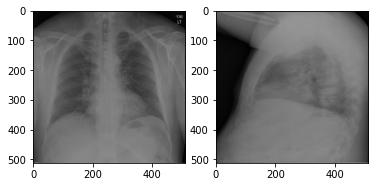

Prediction: no acute pulmonary disease
Caption: no acute pulmonary disease



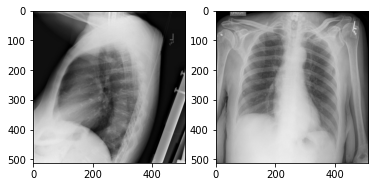

Prediction: stable chest no acute finding
Caption: stable appearance chest no acute finding



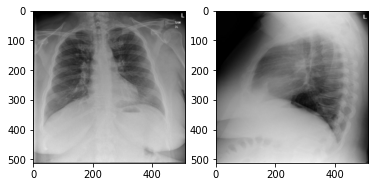

Prediction: heart size size lung clear clear left lobe right upper lobe opacity mediastinal rib cardiopulmonary
Caption: heart size great lung clear calcify mm granuloma right upper lobe underneath second anterior rib end



In [ ]:
for _ in range(3):
    cnn_model.sample(tokenizer)
    print()

In [ ]:
cnn_model.evaluate(tokenizer)

/opt/conda/lib/python3.7/site-packages/urllib3/connectionpool.py:1020: InsecureRequestWarning: Unverified HTTPS request is being made to host 'docs.google.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
/opt/conda/lib/python3.7/site-packages/urllib3/connectionpool.py:1020: InsecureRequestWarning: Unverified HTTPS request is being made to host 'docs.google.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
/opt/conda/lib/python3.7/site-packages/urllib3/connectionpool.py:1020: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doc-10-0g-docs.googleusercontent.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
/opt/conda/lib/python3

0.019302375577575533

In [ ]:
vgg_model = BaseModel(train_df, test_df, "../input/imagecaption/data/images", LENGTH, tokenizer.vocab_size, 20, "VGG")
vgg_model.train()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

Epoch 0 Train Loss 4.739585744668238 Validation Loss 3.3438035743992502
Epoch 1 Train Loss 1.8370209177088292 Validation Loss 2.0098855233773953
Epoch 2 Train Loss 1.0739887164246222 Validation Loss 1.7135156218598528
Epoch 3 Train Loss 0.8287676548735695 Validation Loss 1.5274192792613333
Epoch 4 Train Loss 0.6884818014150821 Validation Loss 1.3961921668634183
Epoch 5 Train Loss 0.5879679319466123 Validation Loss 1.3053115344629056
Epoch 6 Train Loss 0.5119510430912053 Validation Loss 1.1957088956018773
Epoch 7 Train Loss 0.45474836873526897 Validation Loss 1.1169995592861641
Epoch 8 Train Loss 0.41011537125577097 Validation Loss 1.0376094507008065
Epoch 9 Train Loss 0.37385331029477326 Validation Loss 0.9908205997653123
Epoch 10 Train Loss 0.34341488618935856 Validation Loss 0.9150628607447554
Epoch 11 Train Loss 0.3186183258983659 Validation Loss 0.8739939869903937
Epoch 12 Train Loss 0.2967119921716104 Validation Loss 0.829050774981336
Epoch 13 Train Loss 0.2778092582496057 Validat

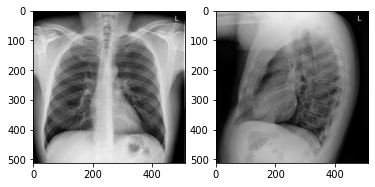

Prediction: no acute disease
Caption: no acute disease



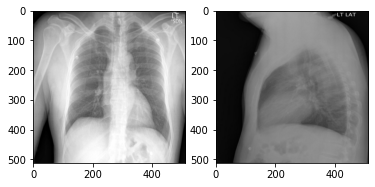

Prediction: no acute cardiopulmonary abnormality
Caption: no acute cardiopulmonary abnormality



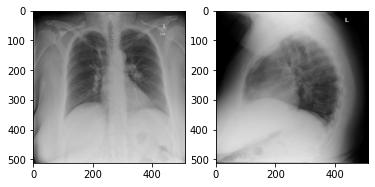

Prediction: left left no opacity opacity appear may atelectasis xxxx may may ct opacity no acute cardiopulmonary abnormality abnormality lobe no fracture no no normal atelectasis rib finding
Caption: left perihilar nodular opacity redemonstrated appear dense may granulomatous desire one may consider ct characterization no acute cardiopulmonary abnormality redemonstrated azygos lobe no fracture visible clinical concern persists consider dedicate rib series



In [ ]:
for _ in range(3):
    vgg_model.sample(tokenizer)
    print()

In [ ]:
vgg_model.evaluate(tokenizer)

0.023878927847639245

In [ ]:
dn_model = BaseModel(train_df, test_df, "../input/imagecaption/data/images", LENGTH, tokenizer.vocab_size, 20, "DenseNet")
dn_model.train()

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

Epoch 0 Train Loss 4.524303474781676 Validation Loss 3.0736455801056652
Epoch 1 Train Loss 1.6700991917841184 Validation Loss 1.948861351827296
Epoch 2 Train Loss 1.0018867483790617 Validation Loss 1.6547120984007673
Epoch 3 Train Loss 0.7819207306974423 Validation Loss 1.5029027374779307
Epoch 4 Train Loss 0.6529420118154206 Validation Loss 1.3804091898406423
Epoch 5 Train Loss 0.5640464216840934 Validation Loss 1.264982521533966
Epoch 6 Train Loss 0.4997323062849341 Validation Loss 1.1978925161245393
Epoch 7 Train Loss 0.4511530489099692 Validation Loss 1.115140858219891
Epoch 8 Train Loss 0.411365775264198 Validation Loss 1.0552326702490085
Epoch 9 Train Loss 0.3772824301112513 Validation Loss 0.9857691729941019
Epoch 10 Train Loss 0.34917997675282614 Validation Loss 0.9358668312793825
Epoch 11 Train Loss 0.32510849069919645 Validation Loss 0.8914612727921184
Epoch 12 Train Loss 0.3042897506622794 Validation Loss 0.8392519558348307
Epoch 13 Train Loss 0.2851816813768067 Validation L

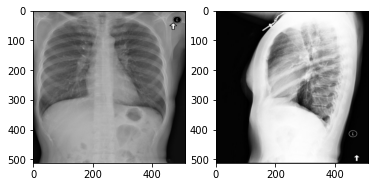

Prediction: no acute cardiopulmonary process
Caption: no acute cardiopulmonary process


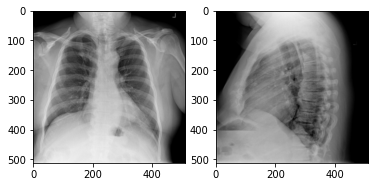

Prediction: no acute cardiopulmonary abnormality
Caption: no acute cardiopulmonary abnormality


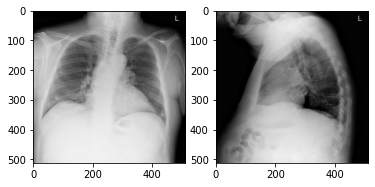

Prediction: normal increase heart left normal normal size lateral xxxx xxxx prior study may pulmonary disease xxxx xxxx left within xxxx chest xxxx xxxx process process disease
Caption: vague increase sclerotic focus overlie posterior spine lateral xxxx xxxx prior study although may artifact pulmonary density xxxx sclerotic focus within thoracic xxxx can not exclude bone scan would helpful evaluate metastatic disease bone


In [ ]:
for _ in range(3):
    dn_model.sample(tokenizer)

In [ ]:
dn_model.evaluate(tokenizer)

0.021450615937436992

In [ ]:
chex_model = BaseModel(train_df, test_df, "../input/imagecaption/data/images", LENGTH, tokenizer.vocab_size, 20, "ChexNet")
chex_model.train()

Epoch 0 Train Loss 4.914412662849664 Validation Loss 3.477356154744218
Epoch 1 Train Loss 1.9410196742656067 Validation Loss 2.029426065886893
Epoch 2 Train Loss 1.0771238666883907 Validation Loss 1.6573771034798972
Epoch 3 Train Loss 0.8077638745307922 Validation Loss 1.4957519217235287
Epoch 4 Train Loss 0.6669808167108098 Validation Loss 1.3646911426288326
Epoch 5 Train Loss 0.5727239588032598 Validation Loss 1.2654386395361366
Epoch 6 Train Loss 0.5049910657339215 Validation Loss 1.1967991445122697
Epoch 7 Train Loss 0.4536481425628899 Validation Loss 1.1124475089515127
Epoch 8 Train Loss 0.41160842776298523 Validation Loss 1.052473577057443
Epoch 9 Train Loss 0.37592448146076674 Validation Loss 0.9787236801007899
Epoch 10 Train Loss 0.3458159346573101 Validation Loss 0.9237061651741586
Epoch 11 Train Loss 0.3202006911268886 Validation Loss 0.8665564685333066
Epoch 12 Train Loss 0.29778424280215493 Validation Loss 0.8185734116449589
Epoch 13 Train Loss 0.278695922136677 Validation 

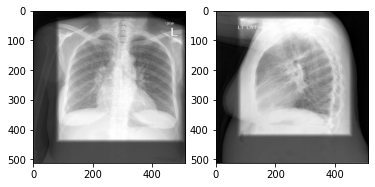

Prediction: opacity acute may represent heart chest no interstitial no xxxx chest
Caption: diffuse reticulonodular pattern bilaterally may represent heart failure opportunistic infection idiopathic interstitial pneumonitis xxxx chest characterization


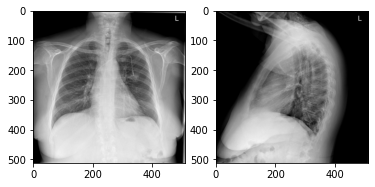

Prediction: no acute cardiopulmonary abnormality
Caption: no acute cardiopulmonary abnormality


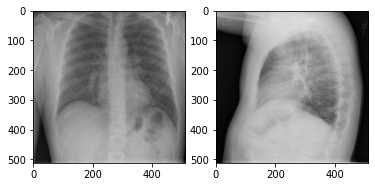

Prediction: no acute radiographic cardiopulmonary process
Caption: no acute radiographic cardiopulmonary process


In [ ]:
for _ in range(3):
    chex_model.sample(tokenizer)

In [ ]:
chex_model.evaluate(tokenizer)

0.01923012377610847